<a href="https://colab.research.google.com/github/LanceryH/C-_stabilization_sensor/blob/main/Kinetic_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

df = pd.read_excel("https://github.com/LanceryH/CNES-stage-2024/raw/main/Data/Kinetic/EC9323_cine.xlsx")

In [33]:
thickness = 0.006

def find_nearest(array, value) -> int:
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def f_water_f1(t: np.ndarray, M0: float, D0: float) -> np.ndarray:
    """Function to aprroximate the curve"""
    tau = (thickness**2) / (np.pi**2 * D0)
    alpha = np.sqrt(D0/((thickness/(4*M0))**2*np.pi))
    return M0*(1-np.exp(-7.3*(t/(tau*np.pi**2))**0.75))+alpha*np.log(t+0.1)

def f_cern_f1(t: np.ndarray, M0: float, D0: float) -> np.ndarray:
    """Function to aprroximate the first step of the curve"""
    tau = (thickness**2) / (np.pi**2 * D0)
    J0 = D0 / thickness
    return (2*J0*M0/thickness*np.sqrt(np.pi*tau*t))

def f_cern_f2(t: np.ndarray, M0: float, D0: float) -> np.ndarray:
    """Function to aprroximate the second step of the curve"""
    tau = (thickness**2) / (np.pi**2 * D0)
    J0 = D0 / thickness
    alpha = np.sqrt(D0/((thickness/(4*M0))**2*np.pi))
    return (4*J0*M0*tau/thickness*(1-np.exp(-(t/(tau)))))+alpha*np.log(t+0.1)

def f_water(t, M0, D0):
    """Function of the water method"""
    try:
        return f_water_f1(t, M0, D0)
    except:
        return np.zeros_like(t)

def f_cern(t, M0, D0):
    """Function of the cern method"""
    tau = (thickness**2) / (np.pi**2 * D0)
    y_fit = np.zeros(len(t))
    try:
        y_fit[t<tau] = f_cern_f1(t[t<tau], M0, D0)
    except:
        pass
    try:
        y_fit[t>tau] = f_cern_f2(t[t>tau], M0, D0) \
            - f_cern_f2(t[t>=tau], M0, D0)[0] \
                + y_fit[t<tau][-1]
    except:
        pass
    return y_fit

<ipython-input-33-a2988d8667f4>:24: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt(D0/((thickness/(4*M0))**2*np.pi))


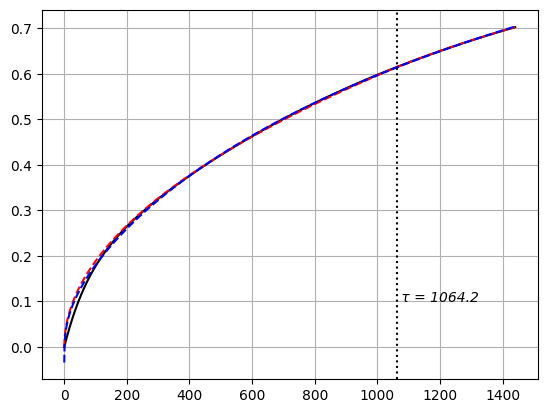

In [34]:
tml = df["pred expo1 [%]"].to_numpy()[:1441]
time = df["Time [min]"].to_numpy()[:1441]

Mm = max(tml)
i2 = find_nearest(tml,value=0.4*Mm)
i1 = find_nearest(tml,value=0.1*Mm)
sqrt_t1 = np.sqrt(time)[i1]
sqrt_t2 = np.sqrt(time)[i2]
slope, _ = np.polyfit(np.sqrt(time)[(np.sqrt(time)>sqrt_t1) & (np.sqrt(time)<sqrt_t2)],
                      tml[(np.sqrt(time)>sqrt_t1) & (np.sqrt(time)<sqrt_t2)], 1)
D = slope**2 * (thickness / (4 * Mm))**2 * np.pi

params_ini = 0.4, 1e-9
params_opt_cern, _ = curve_fit(f_cern, time, tml, params_ini, maxfev = 2000)
params_opt_water, _ = curve_fit(f_water, time, tml, params_ini, maxfev = 2000)
tau_opt = (thickness**2) / (np.pi**2 * params_opt_cern[1])

plt.figure()
plt.plot(time, tml, color="black")
plt.plot(time, f_cern(time, *params_opt_cern), "--r")
plt.plot(time, f_water(time, *params_opt_water), "--b")
if tau_opt < max(time):
    plt.axvline(x=tau_opt, color="black", linestyle=":")
    plt.text(tau_opt, 0.1, f' τ = {np.round(tau_opt,2)}', style='italic')
plt.grid()
plt.show()

In [35]:
alpha_cern = np.sqrt(params_opt_cern[1]/((thickness/(4*params_opt_cern[0]))**2*np.pi))
alpha_water = np.sqrt(params_opt_water[1]/((thickness/(4*params_opt_water[0]))**2*np.pi))
print(alpha_cern, alpha_water)

0.03773121136301324 0.01476679644304688


On recherche maintenant l'equation pol de alpha du matériaux

In [36]:
temperatures = [25,50,75,100,125]
alphas_cern = []
alphas_cern_sum = [0]
alphas_water = []
alphas_water_sum = [0]

for ind_i, val_i in enumerate(temperatures):
    params_ini = 0.2, 1e-9
    params_opt_cern, _ = curve_fit(f_cern, df["Time [min]"].to_numpy()[:1441], df[f"pred expo{ind_i+1} [%]"].to_numpy()[:1441], params_ini, maxfev = 2000)
    params_opt_water, _ = curve_fit(f_water, df["Time [min]"].to_numpy()[:1441], df[f"pred expo{ind_i+1} [%]"].to_numpy()[:1441], params_ini, maxfev = 2000)
    alphas_cern.append(np.sqrt(params_opt_cern[1]/((thickness/(4*params_opt_cern[0]))**2*np.pi)))
    alphas_water.append(np.sqrt(params_opt_water[1]/((thickness/(4*params_opt_water[0]))**2*np.pi)))
    alphas_cern_sum.append(alphas_cern[-1]+alphas_cern_sum[-1])
    alphas_water_sum.append(alphas_water[-1]+alphas_water_sum[-1])

alphas_cern_sum.remove(0)
alphas_water_sum.remove(0)

<ipython-input-33-a2988d8667f4>:24: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt(D0/((thickness/(4*M0))**2*np.pi))
<ipython-input-33-a2988d8667f4>:11: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt(D0/((thickness/(4*M0))**2*np.pi))
<ipython-input-33-a2988d8667f4>:12: RuntimeWarning: invalid value encountered in power
  return M0*(1-np.exp(-7.3*(t/(tau*np.pi**2))**0.75))+alpha*np.log(t+0.1)


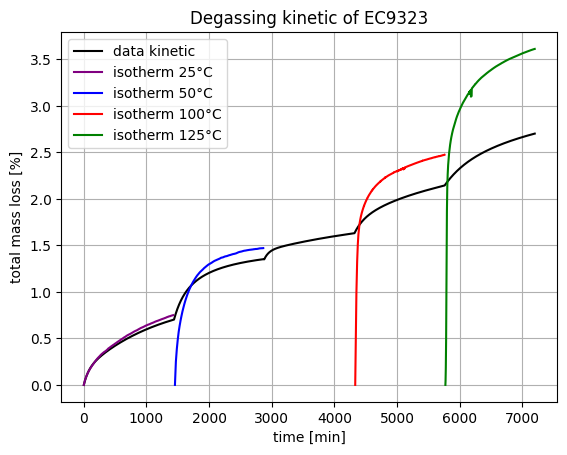

In [37]:
plt.title("Degassing kinetic of EC9323")
plt.plot(df["Time [min]"], df["TML [%]"], label="data kinetic", color="black")
plt.plot(df["Time [min] 25°C"][df["Time [min] 25°C"].to_numpy()<1440], df["TML [%] 25°C"][df["Time [min] 25°C"].to_numpy()<1440], label="isotherm 25°C", color="purple")
plt.plot(df["Time [min] 50°C shift"][df["Time [min] 50°C shift"].to_numpy()<2880], df["TML [%] 50°C"][df["Time [min] 50°C shift"].to_numpy()<2880], label="isotherm 50°C", color="b")
plt.plot(df["Time [min] 100°C shift"][df["Time [min] 100°C shift"].to_numpy()<1440*4], df["TML [%] 100°C"][df["Time [min] 100°C shift"].to_numpy()<1440*4], label="isotherm 100°C", color="r")
plt.plot(df["Time [min] 125°C shift"][df["Time [min] 125°C shift"].to_numpy()<1440*5], df["TML [%] 125°C"][df["Time [min] 125°C shift"].to_numpy()<1440*5], label="isotherm 125°C", color="g")
plt.xlabel("time [min]")
plt.ylabel("total mass loss [%]")
plt.legend()
plt.grid()
plt.show()

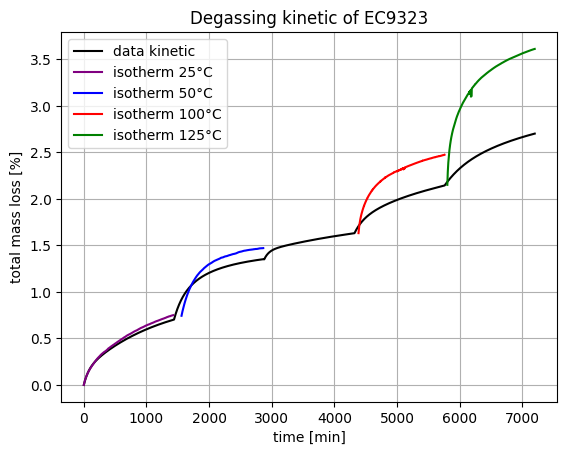

In [38]:
plt.title("Degassing kinetic of EC9323")
plt.plot(df["Time [min]"], df["TML [%]"], label="data kinetic", color="black")
plt.plot(df["Time [min] 25°C"][df["Time [min] 25°C"].to_numpy()<1440], df["TML [%] 25°C"][df["Time [min] 25°C"].to_numpy()<1440], label="isotherm 25°C", color="purple")
plt.plot(df["Time [min] 50°C shift"][df["Time [min] 50°C shift"].to_numpy()<2880][df["TML [%] 50°C"]>df["TML [%]"][1440]],
         df["TML [%] 50°C"][df["Time [min] 50°C shift"].to_numpy()<2880][df["TML [%] 50°C"]>df["TML [%]"][1440]],
         label="isotherm 50°C", color="b")
plt.plot(df["Time [min] 100°C shift"][df["Time [min] 100°C shift"].to_numpy()<1440*4][df["TML [%] 100°C"]>df["TML [%]"][1440*3]],
         df["TML [%] 100°C"][df["Time [min] 100°C shift"].to_numpy()<1440*4][df["TML [%] 100°C"]>df["TML [%]"][1440*3]],
         label="isotherm 100°C", color="r")
plt.plot(df["Time [min] 125°C shift"][df["Time [min] 125°C shift"].to_numpy()<1440*5][df["TML [%] 125°C"]>df["TML [%]"][1440*4]],
         df["TML [%] 125°C"][df["Time [min] 125°C shift"].to_numpy()<1440*5][df["TML [%] 125°C"]>df["TML [%]"][1440*4]],
         label="isotherm 125°C", color="g")
plt.xlabel("time [min]")
plt.ylabel("total mass loss [%]")
plt.legend()
plt.grid()
plt.show()

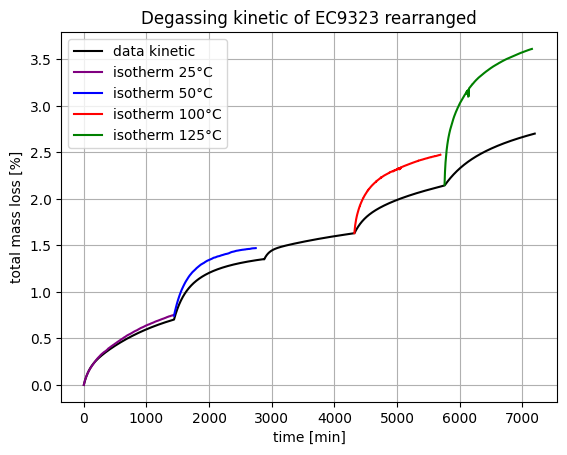

In [39]:
plt.title("Degassing kinetic of EC9323 rearranged")
plt.plot(df["Time [min]"], df["TML [%]"], label="data kinetic", color="black")
plt.plot(df["Time [min] 25°C"][df["Time [min] 25°C"].to_numpy()<1440], df["TML [%] 25°C"][df["Time [min] 25°C"].to_numpy()<1440], label="isotherm 25°C", color="purple")
plt.plot(df["Time [min] 50°C shift"][df["Time [min] 50°C shift"].to_numpy()<2880][df["TML [%] 50°C"]>df["TML [%]"][1440]].to_numpy()-df["Time [min] 50°C shift"][df["Time [min] 50°C shift"].to_numpy()<2880][df["TML [%] 50°C"]>df["TML [%]"][1440]].to_numpy()[0]+1440,
         df["TML [%] 50°C"][df["Time [min] 50°C shift"].to_numpy()<2880][df["TML [%] 50°C"]>df["TML [%]"][1440]],
         label="isotherm 50°C", color="b")
plt.plot(df["Time [min] 100°C shift"][df["Time [min] 100°C shift"].to_numpy()<1440*4][df["TML [%] 100°C"]>df["TML [%]"][1440*3]].to_numpy()-df["Time [min] 100°C shift"][df["Time [min] 100°C shift"].to_numpy()<1440*4][df["TML [%] 100°C"]>df["TML [%]"][1440*3]].to_numpy()[0]+1440*3,
         df["TML [%] 100°C"][df["Time [min] 100°C shift"].to_numpy()<1440*4][df["TML [%] 100°C"]>df["TML [%]"][1440*3]],
         label="isotherm 100°C", color="r")
plt.plot(df["Time [min] 125°C shift"][df["Time [min] 125°C shift"].to_numpy()<1440*5][df["TML [%] 125°C"]>df["TML [%]"][1440*4]].to_numpy()-df["Time [min] 125°C shift"][df["Time [min] 125°C shift"].to_numpy()<1440*5][df["TML [%] 125°C"]>df["TML [%]"][1440*4]].to_numpy()[0]+1440*4,
         df["TML [%] 125°C"][df["Time [min] 125°C shift"].to_numpy()<1440*5][df["TML [%] 125°C"]>df["TML [%]"][1440*4]],
         label="isotherm 125°C", color="g")
plt.xlabel("time [min]")
plt.ylabel("total mass loss [%]")
plt.legend()
plt.grid()
plt.show()

In [40]:
data_long_2_comparre = [(np.interp(np.linspace(1440*0,1440*1,len(df["Time [min]"][1440*0:1440*1].to_numpy())),
                                  df["Time [min] 25°C"][df["Time [min] 25°C"].to_numpy()<1440*1][df["TML [%] 25°C"]>df["TML [%]"][1440*0]].to_numpy(),
                                  df["TML [%] 25°C"][df["Time [min] 25°C"].to_numpy()<1440*1][df["TML [%] 25°C"]>df["TML [%]"][1440*0]])-df["TML [%]"].to_numpy()[1440*0:1440*1])*100/df["TML [%]"].to_numpy()[1440],
                        (np.interp(np.linspace(1440*1,1440*2,len(df["Time [min]"][1440*1:1440*2].to_numpy())),
                                  df["Time [min] 50°C shift"][df["Time [min] 50°C shift"].to_numpy()<1440*2][df["TML [%] 50°C"]>df["TML [%]"][1440*1]].to_numpy(),
                                  df["TML [%] 50°C"][df["Time [min] 50°C shift"].to_numpy()<1440*2][df["TML [%] 50°C"]>df["TML [%]"][1440*1]])-df["TML [%]"].to_numpy()[1440*1:1440*2])*100/df["TML [%]"].to_numpy()[1440*2],
                        (np.interp(np.linspace(1440*3,1440*4,len(df["Time [min]"][1440*3:1440*4].to_numpy())),
                                  df["Time [min] 100°C shift"][df["Time [min] 100°C shift"].to_numpy()<1440*4][df["TML [%] 100°C"]>df["TML [%]"][1440*3]].to_numpy(),
                                  df["TML [%] 100°C"][df["Time [min] 100°C shift"].to_numpy()<1440*4][df["TML [%] 100°C"]>df["TML [%]"][1440*3]])-df["TML [%]"].to_numpy()[1440*3:1440*4])*100/df["TML [%]"].to_numpy()[1440*4],
                        (np.interp(np.linspace(1440*4,1440*5,len(df["Time [min]"][1440*4:1440*5].to_numpy())),
                                  df["Time [min] 125°C shift"][df["Time [min] 125°C shift"].to_numpy()<1440*5][df["TML [%] 125°C"]>df["TML [%]"][1440*4]].to_numpy(),
                                  df["TML [%] 125°C"][df["Time [min] 125°C shift"].to_numpy()<1440*5][df["TML [%] 125°C"]>df["TML [%]"][1440*4]])-df["TML [%]"].to_numpy()[1440*4:1440*5])*100/df["TML [%]"].to_numpy()[-1]]


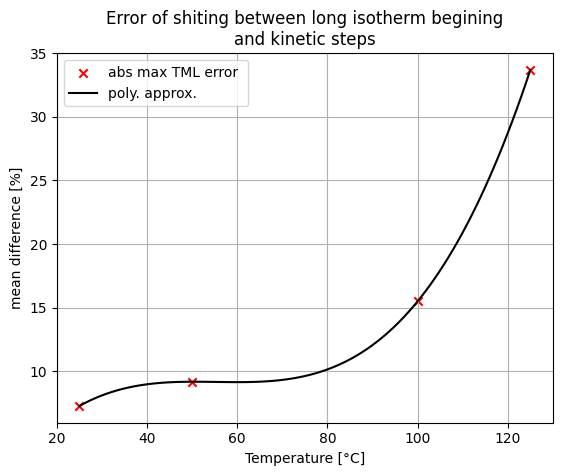

In [41]:
plt.title("Error of shiting between long isotherm begining\nand kinetic steps")
x = np.linspace(25, 125, 100)
temperature_compa = [25,50,100,125]
error = [np.max(data_long_2_comparre[0]),np.max(data_long_2_comparre[1]),np.max(data_long_2_comparre[2]),np.max(data_long_2_comparre[3])]
error_shifting = np.poly1d(np.polyfit(temperature_compa, error, 3))
plt.scatter(temperature_compa, error, label="abs max TML error ", color="r", marker="x")
plt.plot(x, error_shifting(x), label="poly. approx.", color="black")
#plt.plot(x,(alpha_func_obj(x)-alpha_func_cern_sum(x))*100/alpha_func_obj(x)[-1], label="α error gap poly.", color="b")
plt.xlabel("Temperature [°C]")
plt.ylabel("mean difference [%]")
plt.legend()
plt.grid()
plt.show()

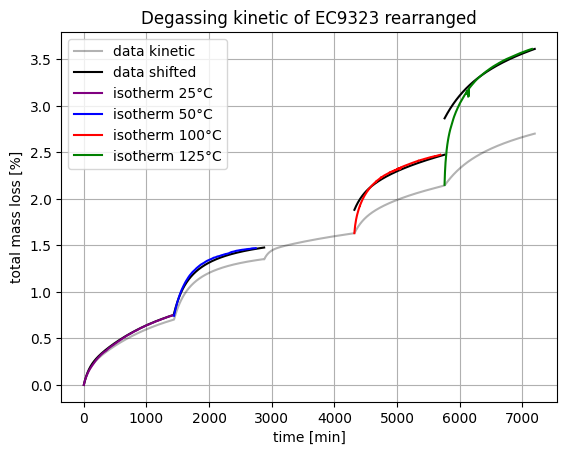

In [42]:
plt.title("Degassing kinetic of EC9323 rearranged")
plt.plot(df["Time [min]"], df["TML [%]"], label="data kinetic", color="black", alpha=0.3)
plt.plot(df["Time [min]"].to_numpy()[4*1440:5*1440],df["TML [%]"].to_numpy()[4*1440:5*1440]*(error_shifting(125)+100)/100, color="black", label="data shifted")
plt.plot(df["Time [min]"].to_numpy()[3*1440:4*1440],df["TML [%]"].to_numpy()[3*1440:4*1440]*(error_shifting(100)+100)/100, color="black")
plt.plot(df["Time [min]"].to_numpy()[1*1440:2*1440],df["TML [%]"].to_numpy()[1*1440:2*1440]*(error_shifting(50)+100)/100, color="black")
plt.plot(df["Time [min]"].to_numpy()[0*1440:1*1440],df["TML [%]"].to_numpy()[0*1440:1*1440]*(error_shifting(25)+100)/100, color="black")

plt.plot(df["Time [min] 25°C"][df["Time [min] 25°C"].to_numpy()<1440], df["TML [%] 25°C"][df["Time [min] 25°C"].to_numpy()<1440], label="isotherm 25°C", color="purple")
plt.plot(df["Time [min] 50°C shift"][df["Time [min] 50°C shift"].to_numpy()<2880][df["TML [%] 50°C"]>df["TML [%]"][1440]].to_numpy()-df["Time [min] 50°C shift"][df["Time [min] 50°C shift"].to_numpy()<2880][df["TML [%] 50°C"]>df["TML [%]"][1440]].to_numpy()[0]+1440,
         df["TML [%] 50°C"][df["Time [min] 50°C shift"].to_numpy()<2880][df["TML [%] 50°C"]>df["TML [%]"][1440]],
         label="isotherm 50°C", color="b")
plt.plot(df["Time [min] 100°C shift"][df["Time [min] 100°C shift"].to_numpy()<1440*4][df["TML [%] 100°C"]>df["TML [%]"][1440*3]].to_numpy()-df["Time [min] 100°C shift"][df["Time [min] 100°C shift"].to_numpy()<1440*4][df["TML [%] 100°C"]>df["TML [%]"][1440*3]].to_numpy()[0]+1440*3,
         df["TML [%] 100°C"][df["Time [min] 100°C shift"].to_numpy()<1440*4][df["TML [%] 100°C"]>df["TML [%]"][1440*3]],
         label="isotherm 100°C", color="r")
plt.plot(df["Time [min] 125°C shift"][df["Time [min] 125°C shift"].to_numpy()<1440*5][df["TML [%] 125°C"]>df["TML [%]"][1440*4]].to_numpy()-df["Time [min] 125°C shift"][df["Time [min] 125°C shift"].to_numpy()<1440*5][df["TML [%] 125°C"]>df["TML [%]"][1440*4]].to_numpy()[0]+1440*4,
         df["TML [%] 125°C"][df["Time [min] 125°C shift"].to_numpy()<1440*5][df["TML [%] 125°C"]>df["TML [%]"][1440*4]],
         label="isotherm 125°C", color="g")
plt.xlabel("time [min]")
plt.ylabel("total mass loss [%]")
plt.legend()
plt.grid()
plt.show()

In [43]:
def f_water_r(t, M0, D0, t0):
    y_fit = np.zeros(len(t))
    alpha = np.sqrt(D0/((thickness/(4*M0))**2*np.pi))
    try:
        y_fit = f_water_f1(t+t0, M0, D0)+alpha*np.log(t+0.001)
    except:
        pass
    return y_fit

In [44]:
iso_tml_r = df["TML [%] 50°C"][df["Time [min] 50°C"].to_numpy()<1440*2]
iso_time_r = df["Time [min] 50°C"][df["Time [min] 50°C"].to_numpy()<1440*2].to_numpy()
cine_time_r = df["Time [min]"].to_numpy()[1*1440:2*1440]-df["Time [min]"].to_numpy()[1*1440:2*1440][0]
cine_tml_r = df["TML [%]"].to_numpy()[1*1440:2*1440]*(error_shifting(50)+100)/100

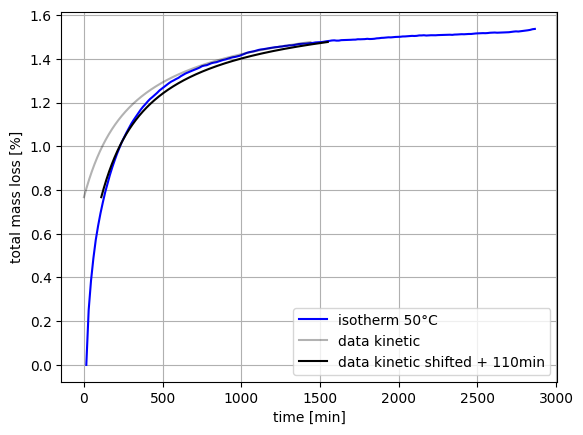

In [45]:
plt.figure()
plt.plot(iso_time_r, iso_tml_r, "b", label="isotherm 50°C")
plt.plot(cine_time_r, cine_tml_r, "black", alpha=0.3, label="data kinetic")
plt.plot(cine_time_r+110, cine_tml_r, "black", label="data kinetic shifted + 110min")
plt.xlabel("time [min]")
plt.ylabel("total mass loss [%]")
plt.legend()
plt.grid()
plt.show()

<ipython-input-33-a2988d8667f4>:12: RuntimeWarning: invalid value encountered in power
  return M0*(1-np.exp(-7.3*(t/(tau*np.pi**2))**0.75))+alpha*np.log(t+0.1)
<ipython-input-33-a2988d8667f4>:12: RuntimeWarning: invalid value encountered in log
  return M0*(1-np.exp(-7.3*(t/(tau*np.pi**2))**0.75))+alpha*np.log(t+0.1)


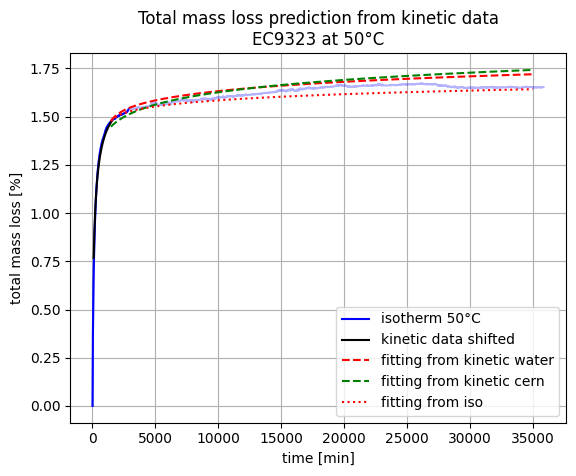

In [46]:
params_ini = 1,1e-9,500
params_kin_wat, _ = curve_fit(f_water_r, cine_time_r, cine_tml_r, params_ini, maxfev = 2000)

params_ini = 1, D
params_kin_cern, _ = curve_fit(f_cern_f2, cine_time_r+100, cine_tml_r, params_ini, maxfev = 2000)

params_ini = 1, D
popt_water, _ = curve_fit(f_water, iso_time_r, iso_tml_r, params_ini, maxfev = 2000)

t_pred = np.linspace(0,35000,1000)

plt.figure()
plt.title("Total mass loss prediction from kinetic data\nEC9323 at 50°C")
plt.plot(df["Time [min] 50°C"],df["TML [%] 50°C"], "b",alpha=0.3)
plt.plot(iso_time_r, iso_tml_r, "b", label="isotherm 50°C")
plt.plot(cine_time_r+100, cine_tml_r, "black", label="kinetic data shifted")
plt.plot(t_pred[t_pred>cine_time_r[-1]], f_water_r(t_pred[t_pred>cine_time_r[-1]],*params_kin_wat), "--r", label="fitting from kinetic water")
plt.plot(t_pred[t_pred>cine_time_r[-1]], f_cern_f2(t_pred[t_pred>cine_time_r[-1]],*params_kin_cern), "--g", label="fitting from kinetic cern")
plt.plot(t_pred[t_pred>cine_time_r[-1]], f_water(t_pred[t_pred>cine_time_r[-1]],*popt_water), ":r", label="fitting from iso")
plt.xlabel("time [min]")
plt.ylabel("total mass loss [%]")
plt.legend()
plt.grid()
plt.show()